Simulation

In [204]:
import numpy as np
import math
import pandas as pd

def cel2kel(Tcelsius: float) -> float:
    """
    Compute the temperature in Kelvin:

    Parameter:
        Tcelsius (float): the temperature in Celsius.

    Returns:
        TKelvin (float): the temperature in Kelvin.    

    Raises:
        ValueError: if the input value is non-positive
    """
    TKelvin = Tcelsius + 273
    return TKelvin 

def isentropic_flow(M: float, T: float, P: float, gamma: float) -> list:
    """
    Compute the static pressure and the static temperature of the isentropic flow, with respect to the Mach number and the pressure and temperature values in ambient conditions.

    Parameters:
        M (float): Mach number
        T (float): ambient temperature
        P (float): ambient pressure (kPa)
        gamma (float): specific heat ratio of the gas

    Returns:
        Out (list): [T, P] -> static temperature and static pressure of the isentropic flow.
    
    Raises:
        ValueError: if any of the input values are non-positive
    """

    if M<0 or T<0 or P<0:
        raise ValueError('M, T, P and gamma must be positive.')
    
    Tout = T * (1 + (gamma - 1)/2 * np.power(M, 2))
    Pout = P * np.power((Tout/ T), gamma/(gamma - 1))
    return [Tout, Pout]


def compressor_stage(Tin:float, Pin:float, PR:float, etta_pol:float, gamma:float) -> list:
    """
    Compute the static pressure and static temperature after a compressor stage.

    Parameters:
        T (float)   : static temperature at the compressor's inlet
        P (float)   : static pressure (kPa) at the compressor's inlet
        PR (float)  : pressure ratio of the compressor stage
        etta_pol (float)    : polytropic efficiency of the stage
        gamma (float)       : specific heat ratio of the gas

    Returns:
        [Tout, Pout] (list): list that contains the static temperature (Kelvin) and pressure (kPa) at the compresor's exit
    """
    if PR<0 or Tin<0 or Pin<0 or gamma < 0:
        raise ValueError('PR, T, P and gamma must be positive.')
    
    if etta_pol<0 or etta_pol>1:
        raise ValueError('The polytropic efficiency is in the range (0,1)')
    
    etta_is = (np.power(PR, (gamma - 1)/gamma) - 1)/(np.power(PR, (gamma - 1)/gamma/ etta_pol) - 1)
    Tout = Tin * (1 + (np.power(PR, (gamma - 1)/gamma) - 1)/etta_is)
    Pout = Pin * PR
    return [Tout, Pout]

def turbine_stage(Tin:float, Pin:float, Wdot:float, etta_is:float, mdot: float, Cp: float, gamma:float) -> list:
    """
    Compute the static pressure and static temperature after the turbine stage

    Parameters:
        T (float)   : static temperature at the turbine's inlet
        P (float)   : static pressure (kPa) at the turbine's inlet
        Wdot (float): Power output of the turbine stage
        etta_is (float)     : isentropic efficiency of the stage
        mdot (float)        : mass flow rate
        Cp   (float)        : specific heat capacity
        gamma (float)       : specific heat ratio of the gas
    """
    Tout    = Tin - Wdot/Cp/mdot
    Toutis  = Tin - (Tin - Tout)/etta_is
    PR      = np.power(Tin/Toutis, gamma/(gamma -1))
    #PR      = np.power(1 - (Tin - Tout)/Tin/etta_is, -gamma/(gamma - 1))
    Pout    = Pin / PR
    return [Tout, Pout]

def Nozzle(Tin:float, Pin:float, Pamb:float, mdot:float, R:float, gamma:float ) ->list:
    """
    Compute the static pressure, the static temperature and the thrust in a nozzle

    Parameters:
        T (float): static temperature at the nozzle's inlet (Kelvin)
        P (float): static pressure at the nozzle's inlet (kPa)
        Pamb (float): ambient static pressure (kPa)
        mdot (float): mass flow rate in the nozzle
        Rair (float): gas constant
        gamma (float): specific heat ratio of the air

    Returns:
        [Tout, Pout, Fn] (list): list that contains the static temperature (Kelvin) and pressure (kPa) at the nozzle's exit and the thrust (kN) produced by the nozzle 
    """
    if Pin > Pamb or Pin<Pamb:
        PRreal = Pin/Pamb 
        PRcrit = np.power( 1 + (gamma -1)/2, gamma/(gamma-1))
        if PRreal>=PRcrit: # choked nozzle
            Pout = Pin/PRcrit
            TRcrit = 1 + (gamma-1)/2 
            Tout = Tin/ TRcrit
            Vout = np.sqrt(gamma*R*Tout*1000)
            rho_out  = Pout/R/Tout
            Aex  = mdot / rho_out/ Vout
            Fn = (Pout - Pamb) * Aex + mdot * Vout / 1000
            # print('Choked')
            # print(f'Thrust: {Fn} kN')
        elif PRreal< PRcrit: # non-choked nozzle
            Pout = Pin/PRreal
            if PRreal > 1:
                Mout = np.sqrt(2/(gamma-1)*(np.power(PRreal, (gamma-1)/gamma)-1))
                if Mout >1:
                    raise ArithmeticError("The Mach number is calculated greater than 1 in a non choked nozzle")
                TRreal = 1 + (gamma -1)/2 * np.power(Mout, 2)
                Tout = Tin/TRreal
                Vout = Mout * np.sqrt(gamma* R*1000* Tout)
                Fn = mdot * Vout /1000
                # print('Not choked')
                # print(f'Thrust: {Fn} kN')
            else:
                Fn = 0
                Tout = -1
        else:
            raise ArithmeticError('Nozzle calculations failed')
    elif Pin < Pamb:
        raise ValueError('Pin < Pamb: this is an infeasible point for the engine')
    
    return [Tout, Pout, Fn]
    
def Entropy(T1:float, T2:float, P1:float, P2:float, Cp:float, R:float) -> float:
    """
    It calculates the entropy production during a process
    Parameters:
        T1 (float): Temperature (K) at the start of the process
        T2 (float): Temperature (K) at the end of the process
        P1 (float): Pressure at the start of teh process
        P2 (float): Pressure at the end of teh process
        Cp (float): Specific heat capacity of the ideal gass (kJ/kgK)
        R  (float): gas constant
    
    Returns:
        Ds (float): The entropy production of the process in (kJ/K)
    """

    Ds = Cp * math.log(np.abs(T2/ T1)) - R * math.log(np.abs(P2/P1))
    return np.abs(Ds)

class Engine:
    def __init__(self, Tamb, constraint = False, FAR_correction = False) -> None:
        """
        Inputs:
            Tamb: the ambient temperature in deg Celsius
            constraint (bool): activate the constraint of the maximum temperature after the burner at 1650 K (default = False)
            FAR_correction (bool): activate the correction loop for FAR, that meets the demands of low temperature after the burner (default = False)
        """
        self.Tamb   = Tamb         # Deg Celsius
        self.Pamb   = 101.325   # kPa
        self.gammac = 1.4       # gamma coefficient of cold fluid
        self.gammah = 1.34      # gamma coefficient of hot fluid
        self.mdotair= 425       # kg/s mass flow
        self.PR_inlet= 1        # Intake pressure ratio
        self.M0     = 0.1       # inlet mach number
        self.BPR    = 10        # By Pass Ratio
        self.Cpc    = 1         # Cp of the cold flow kJ/kg K
        self.Cph    = 1.18      # Cp of the hot flow kJ/kg K
        self.LHV    = 43000     # Lower Heating Value of the fuel Kj/kg
        self.FAR    = 0.025     # Fuel to air ratio
        self.DP_burner = 5      # percentage pressure drop in the burner (%)
        self.ettam_lps = 1      # mechanical efficiency of the low pressure shaft
        self.ettam_hps = 1      # mechanical efficiency of the high pressure shaft
        self.Rair   = 0.287     # Rair kj/kg K
        if constraint:
            self.Tburnermax = 1650  # maximum temperature (Kelvin)
        else:
            self.Tburnermax = 100000000
        self.FAR_flag = FAR_correction

        # Compressor stages
        self.PR_fan = 1.6
        self.etta_pol_fan = 0.935

        self.PR_lpc = 2
        self.etta_pol_lpc = 0.93

        self.PR_hpc = 17.9
        self.etta_pol_hpc = 0.93

        # Turbine stages
        self.etta_is_lpt = 0.92
        self.etta_is_hpt = 0.92
                  
    def calculation(self):
        # isentropic flow calculation
        self.T0, self.P0 = isentropic_flow(self.M0, cel2kel(self.Tamb), self.Pamb, self.gammac)
        
        # Diffuser
        self.P1 = self.PR_inlet * self.P0
        self.T1 = self.T0
        self.modot1 = self.mdotair

        # Compressor Fan
        self.T2, self.P2  = compressor_stage(self.T1, self.P1, self.PR_fan, self.etta_pol_fan, self.gammac)
        self.mdot2   = self.mdotair
        self.Pfan = self.mdotair * self.Cpc * (self.T2 - self.T1) 
        self.Dsfan = Entropy(self.T1, self.T2, self.P1, self.P2, self.Cpc, self.Rair)

        # BPR mass flows separation
        self.mdotBP  = self.BPR / (self.BPR + 1) * self.mdotair
        self.mdotc   = self.mdotair/ (self.BPR + 1)
        
        # LPC compressor
        self.T3, self.P3 = compressor_stage(self.T2, self.P2, self.PR_lpc, self.etta_pol_lpc, self.gammac)
        self.mdot3 = self.mdotc
        self.Plpc   = self.mdotc * self.Cpc * (self.T3- self.T2)
        self.Dslpc = Entropy(self.T2, self.T3, self.P2, self.P3, self.Cpc, self.Rair)
        
        # HPC compressor
        self.T4, self.P4 = compressor_stage(self.T3, self.P3, self.PR_hpc, self.etta_pol_hpc, self.gammac)
        self.mdot4 = self.mdotc
        self.Phpc = self.mdotc * self.Cpc * (self.T4 - self.T3)
        self.Dshpc = Entropy(self.T3, self.T4, self.P3, self.P4, self.Cpc, self.Rair)

        feas = 0
        while feas == 0:
            # Burner
            flag = 0
            self.mdoth = self.mdot4 *(self.FAR + 1)
            self.mdotfuel = self.FAR * self.mdot4
            self.T5    = (self.mdot4 * self.Cpc * self.T4 + self.mdotfuel * self.LHV) / self.Cph / self.mdoth
            if self.T5 > self.Tburnermax:
                self.T5 = self.Tburnermax
                self.mdotfuel = self.mdotc * (self.Cph * self.T5 - self.Cpc * self.T4)/(self.LHV - self.Cph*self.T5)
                self.FAR = self.mdotfuel/self.mdotc
                self.mdoth = self.mdotc * (self.FAR + 1)
                #print(f"The FAR is restricted to the value {self.FAR}, because the temperature after the burner exceeds the limit of {self.Tburnermax} K")
                flag = 1


            self.P5 = (1 - self.DP_burner/100) * self.P4
            self.Dsb = Entropy(self.T4, self.T5, self.P4, self.P5, self.Cph, self.Rair)

            # HPT turbine
            # power output from HPC
            self.Wdot_hpt    = self.Phpc/self.ettam_hps
            [self.T6, self.P6] = turbine_stage(self.T5, self.P5, self.Wdot_hpt, self.etta_is_hpt, self.mdoth, self.Cph, self.gammah)
            self.Phpt = self.mdoth * self.Cph * (self.T6 - self.T5)
            self.Dshpt = Entropy(self.T5, self.T6, self.P5, self.P6, self.Cph, self.Rair)

            # LPT turbine
            # power output from LPC and Fan
            self.Wdot_lpt = (self.Pfan + self.Plpc)/ self.ettam_lps
            [self.T7, self.P7] = turbine_stage(self.T6, self.P6, self.Wdot_lpt, self.etta_is_lpt, self.mdoth, self.Cph, self.gammah)
            self.Plpt = self.mdoth * self.Cph * (self.T7 - self.T6)
            self.Dslpt = Entropy(self.T6, self.T7, self.P6, self.P7, self.Cph, self.Rair)
            if self.P7 < self.Pamb and flag != 1 and self.FAR_flag:
                feas = 0
                self.FAR = self.FAR + 0.00001
            else:
                feas = 1


        # Core nozzle
        # print('Core nozzle:')
        [self.T8, self.P8, self.Fn_c] = Nozzle(self.T7, self.P7, self.Pamb, self.mdoth, self.Rair, self.gammah)
        self.Dsn = Entropy(self.T7, self.T8, self.P7, self.P8, self.Cph, self.Rair)

        # BP nozzle
        # print('BP nozzle:')
        [self.T9, self.P9, self.Fn_bp] = Nozzle(self.T2, self.P2, self.Pamb, self.mdotBP, self.Rair, self.gammac)

        # Total thrust and SFC calculation
        self.F = self.Fn_c + self.Fn_bp
        self.SFC = self.mdotfuel*1000/self.F

    def output(self) -> None:
        """
        Output:
            df: data frame with the results of temperature, pressure and power in each station and
            performance: list that contains the total thrust (kN) and the SFC (g/kNs)
        """
        self.calculation()
        results = {
            'stage': ['Isentropic flow', 'Diffuser', 'Fan', 'LPC', 'HPC', 'Burner', 'HPT', 'LPT', 'Core Nozzle', 'BP nozzle'],
            'Presure (kPa)': [self.P0, self.P1, self.P2, self.P3, self.P4, self.P5, self.P6, self.P7, self.P8, self.P9],
            'Temperature (Kelvin)': [self.T0, self.T1, self.T2, self.T3, self.T4, self.T5, self.T6, self.T7, self.T8, self.T9],
            'Power (kW)': ['-', '-', self.Pfan, self.Plpc, self.Phpc, '-', self.Phpt, self.Plpt, '-', '-']
        }
        df = pd.DataFrame(results)
        performance = [self.F, self.SFC, self.FAR]

        return df, performance

        



Run a single simulation to a given Tamb without constraint

In [219]:
res = Engine(5) ################### Change to Engine(Tamb, constraint = True) if you want to add the constraint of max temp
df, performance = res.output()
if df.iloc[8,2] > 0:
    status = "feasible"
else:
    status = "non-feasible"
print(df)
print(f"Thrust:     {performance[0]} kN")
print(f"SFC:        {performance[1]} g/kNs")
print(f"FAR:        {performance[2]}")
print(f"status:     {status}")

             stage  Presure (kPa)  Temperature (Kelvin)    Power (kW)
0  Isentropic flow     102.036050            278.556000             -
1         Diffuser     102.036050            278.556000             -
2              Fan     163.257680            321.578380  18284.511703
3              LPC     326.515360            397.895637   2948.621281
4              HPC    5844.624942            965.317683  21923.124516
5           Burner    5552.393695           1686.910032             -
6              HPT    1343.943748           1217.772333 -21923.124516
7              LPT     173.018727            763.399913 -21233.132985
8      Core Nozzle     101.325000            666.485806             -
9        BP nozzle     101.325000            280.607405             -
Thrust:     129.39021462916537 kN
SFC:        7.465086086126399 g/kNs
FAR:        0.025
status:     feasible


Run multiple simulations in a certain temperature regime

    Tamb (Celsius)   Thrust kN  SFC g/kNs    FAR  Feasibility
0               -5  129.021635   7.486412  0.025            1
1               -1  129.191064   7.476594  0.025            1
2                3  129.331548   7.468472  0.025            1
3                7  129.440716   7.462174  0.025            1
4               11  129.515667   7.457855  0.025            1
5               15  129.552839   7.455715  0.025            1
6               19  129.547794   7.456006  0.025            1
7               23  129.494895   7.459052  0.025            1
8               27  129.386814   7.465282  0.025            1
9               31  129.213743   7.475281  0.025            1
10              35  128.962059   7.489870  0.025            1


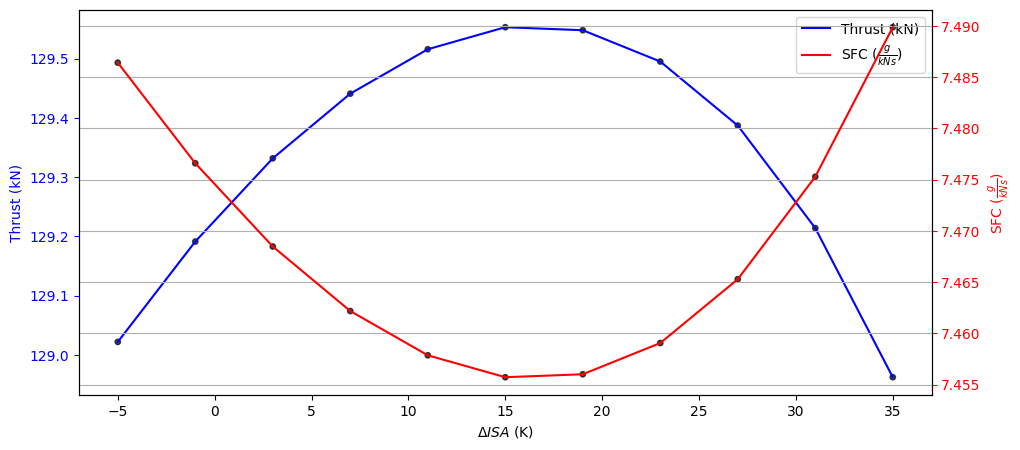

In [231]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

DISA = np.arange(-5,35+4,4)
i_range = range(1,len(DISA)+1)
names_list = [f"data_{i}" for i in i_range]


datalib = {}
perf_df = pd.DataFrame({"Tamb (Celsius)":[],
                        "Thrust kN": [],
                        "SFC g/kNs": [],
                        "FAR":[],
                        "Feasibility": []})
for i in i_range:
    name = names_list[i-1]
    Tamb = DISA[i-1]
    # running the analysis
    res = Engine(Tamb) ################### Change to Engine(Tamb, constraint = True) if you want to add the constraint of max temp
    df , performance = res.output()
    Tni = df.iloc[8,2]
    if Tni < 0:
        nr = {"Tamb (Celsius)": Tamb,
                        "Thrust kN": performance[0],
                        "SFC g/kNs": performance[1],
                        "FAR": performance[2],
                        "Feasibility": 0}
    else:
        nr = {"Tamb (Celsius)": Tamb,
                        "Thrust kN": performance[0],
                        "SFC g/kNs": performance[1],
                        "FAR": performance[2],
                        "Feasibility": 1}
    datalib[name] = df
    perf_df.loc[len(perf_df)] = nr

print(perf_df)

perf_df_feas = perf_df[perf_df["Feasibility"] == 1]
DISA_feas = DISA[0:len(perf_df_feas)]
fig, ax1 = plt.subplots(figsize= (11,5))
sizes = [15 for _ in range(len(DISA_feas))]  # Marker sizes
ax1.plot(DISA_feas, perf_df_feas["Thrust kN"], 'b-', label='Thrust (kN)')
ax1.scatter(DISA_feas, perf_df_feas["Thrust kN"] , color='black', s = sizes, marker='o', alpha=0.7)
ax1.set_xlabel(r'$\Delta ISA$ (K)')
ax1.set_ylabel('Thrust (kN)', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(DISA_feas, perf_df_feas["SFC g/kNs"], 'r-', label=r'SFC ($\frac{g}{kNs}$)')
ax2.scatter(DISA_feas, perf_df_feas["SFC g/kNs"] , color='black', s = sizes, marker='o', alpha=0.7)
ax2.set_ylabel(r'SFC ($\frac{g}{kNs}$)', color='r')
ax2.tick_params('y', colors='r')

# Adding a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='best')

# Add gridlines
plt.grid(True)

# Show plot
plt.show()



Plot the results of a certain simulation

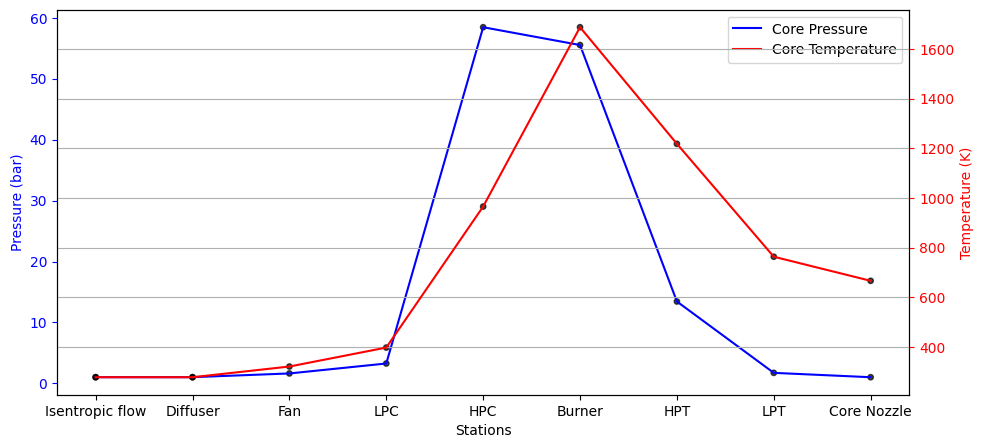

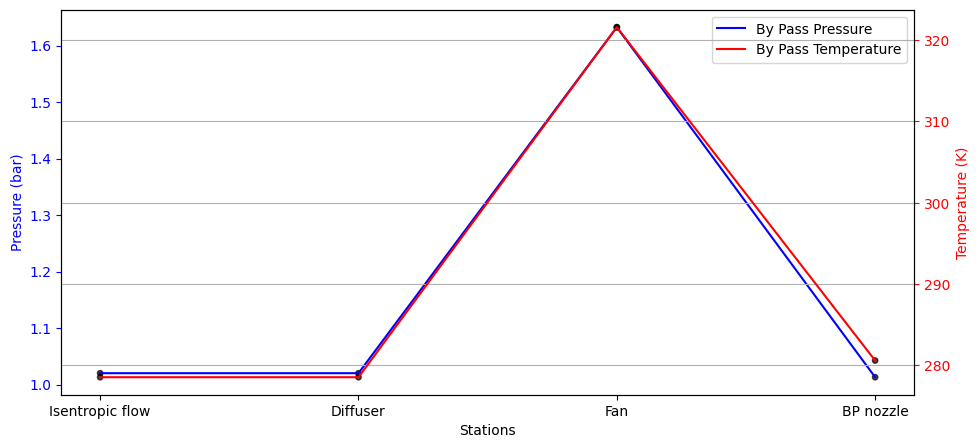

In [232]:

res = Engine(5) ################### Change to Engine(Tamb, constraint = True) if you want to add the constraint of max temp
df, performance = res.output()

fig, ax1 = plt.subplots(figsize= (11,5))

sizes = [15 for _ in range(len(df.iloc[0:-1,1]))]
ax1.plot(df.iloc[0:-1,0], df.iloc[0:-1,1]/100, 'b-', label='Core Pressure')
ax1.scatter(df.iloc[0:-1,0], df.iloc[0:-1,1]/100 , color='black', s = sizes, marker='o', alpha=0.7)
ax1.set_xlabel('Stations')
ax1.set_ylabel('Pressure (bar)', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(df.iloc[0:-1,0], df.iloc[0:-1,2], 'r-', label='Core Temperature')
ax2.scatter(df.iloc[0:-1,0], df.iloc[0:-1,2], color='black', s = sizes, marker='o', alpha=0.7)
ax2.set_ylabel('Temperature (K)', color='r')
ax2.tick_params('y', colors='r')


# Adding a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='best')

# Add gridlines
plt.grid(True)

# Show plot
plt.show()

fig, ax1 = plt.subplots(figsize= (11,5))
sizes = [15 for _ in range(len(df.iloc[[0,1,2,-1],1]))]
ax1.plot(df.iloc[[0,1,2,-1],0], df.iloc[[0,1,2,-1],1]/100, 'b-', label='By Pass Pressure')
ax1.scatter(df.iloc[[0,1,2,-1],0], df.iloc[[0,1,2,-1],1]/100 , color='black', s = sizes, marker='o', alpha=0.7)
ax1.set_xlabel('Stations')
ax1.set_ylabel('Pressure (bar)', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(df.iloc[[0,1,2,-1],0], df.iloc[[0,1,2,-1],2], 'r-', label='By Pass Temperature')
ax2.scatter(df.iloc[[0,1,2,-1],0], df.iloc[[0,1,2,-1],2], color='black', s = sizes, marker='o', alpha=0.7)
ax2.set_ylabel('Temperature (K)', color='r')
ax2.tick_params('y', colors='r')


# Adding a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='best')

# Add gridlines
plt.grid(True)

# Show plot
plt.show()

Plot the T-s diagramm of the core of the engine

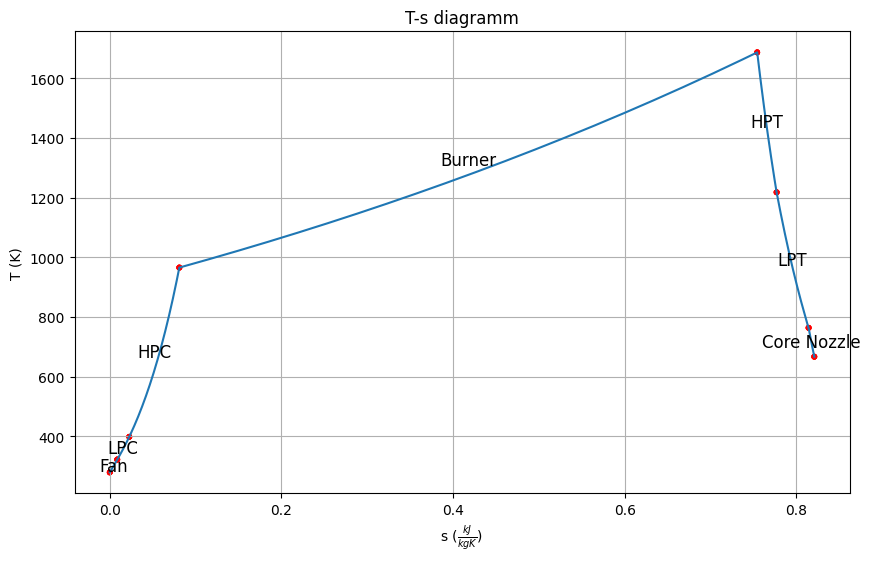

In [233]:
# curve functions 
def process(T1:float, T2:float, s1:float, s2:float) -> None:
    """ 
    It calculates the points for an isobaric process
    Parameters:
        T1 (float): Temperature at the start of the process
        T2 (float): Temperature at the end of the process
        s1 (float): Entropy at the start of the process
        s2 (float): Entropy at the end of the process
    
    Returns:
        ss (numpy array): np.array that contains the entropy points for the process
        tt (numpy array): np.array that contains the temperature points
    """
    
    coeff = (s2 - s1)/math.log(T2/T1)
    ss = np.linspace(s1, s2, num = 40)
    tt = []
    for i in ss:
        t = T1* math.exp((i-s1)/coeff)
        tt.append(t)
    return ss, tt



res = Engine(5) ################### Change to Engine(Tamb, constraint = True) if you want to add the constraint of max temp
df, performance = res.output()

s = [0, res.Dsfan, res.Dslpc, res.Dshpc, res.Dsb, res.Dshpt, res.Dslpt, res.Dsn]
slist =np.cumsum(s) 
Tlist = list(df.iloc[1:-1,2])

S = []
T = []
for i in np.arange(0,len(slist)-1):
    s1, s2 = slist[i], slist[i+1]
    t1, t2 = Tlist[i], Tlist[i+1]
    ss, tt = process(t1, t2, s1, s2)
    S.extend(list(ss))
    T.extend(list(tt))

#Plotting
sizes = [10 for _ in range(len(Tlist))]  # Marker sizes
plt.figure(figsize=(10, 6))  # Adjust the width and height of the figure as needed
plt.plot(S, T)
for i, name in enumerate(df.iloc[2:-1,0]):
    plt.text(np.mean([slist[i],slist[i+1]]), np.mean([Tlist[i],Tlist[i+1]]), name, fontsize=12, ha='center', va='center')
    plt.scatter(slist, Tlist, color='red', s = sizes, marker='o', alpha=0.7, label='Data Points')
# Adding labels and title
plt.xlabel(r's ($\frac{kJ}{kg K}$)')
plt.ylabel('T (K)')
plt.title('T-s diagramm')
plt.grid("on")

# Show plot
plt.show()


